# EDA

In [2]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', None)

In [3]:
data1 = pd.read_csv(r'C:\Users\Vanuhi\Documents\v4nui\Project\Podcast_listening_time_prediction\playground-series-s5e4/train.csv')
data2 = pd.read_csv(r'C:\Users\Vanuhi\Documents\v4nui\Project\Podcast_listening_time_prediction\playground-series-s5e4/test.csv')

train = data1.copy()
test = data2.copy()

train.head(10)
test.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [6]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,250000.00,874999.50,72168.93,750000.00,812499.75,874999.50,937499.25,999999.00
Episode_Length_minutes,221264.00,419.30,166854.50,2.47,35.78,63.97,94.15,78486264.00
Host_Popularity_percentage,250000.00,59.72,22.88,2.49,39.25,59.90,79.39,117.76
Guest_Popularity_percentage,201168.00,52.19,28.45,0.00,28.32,53.36,76.56,116.82
Number_of_Ads,250000.00,1.36,4.27,0.00,0.00,1.00,2.00,2063.00


In [4]:
train = train.fillna(train.median(numeric_only= True))
test = test.fillna(test.median(numeric_only= True))

In [6]:
from my_functions import lower_case

lower_case(train, ['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
        'Genre', 'Host_Popularity_percentage', 'Publication_Day',
        'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
        'Episode_Sentiment', 'Listening_Time_minutes'])

lower_case(test, ['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
        'Genre', 'Host_Popularity_percentage', 'Publication_Day',
        'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
        'Episode_Sentiment'])

In [7]:
days_encoding = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

train['weekday_encoded'] = train['publication_day'].map(days_encoding)

test['weekday_encoded'] = test['publication_day'].map(days_encoding)

publication_encoding = {
    'Morning': 0,
    'Afternoon': 1,
    'Evening': 2,
    'Night': 4
}

train['publication_encoded'] = train['publication_time'].map(publication_encoding)

test['publication_encoded'] = test['publication_time'].map(publication_encoding)

train = train.drop(columns=['publication_day', 'publication_time'])

test = test.drop(columns=['publication_day', 'publication_time'])

print("Train df after encoding of day and time: \n", train.head(3))
print("Test df after encoding of day and time: \n", test.head(3))

Train df after encoding of day and time: 
    id     podcast_name episode_title  episode_length_minutes       genre  \
0   0  Mystery Matters    Episode 98                   63.84  True Crime   
1   1    Joke Junction    Episode 26                  119.80      Comedy   
2   2   Study Sessions    Episode 16                   73.90   Education   

   host_popularity_percentage  guest_popularity_percentage  number_of_ads  \
0                       74.81                        53.58            0.0   
1                       66.95                        75.95            2.0   
2                       69.97                         8.97            0.0   

  episode_sentiment  listening_time_minutes  weekday_encoded  \
0          Positive                31.41998                4   
1          Negative                88.01241                6   
2          Negative                44.92531                2   

   publication_encoded  
0                    4  
1                    1  
2          

In [8]:
episode_mapping = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
}

train['episode_sentiment_encoded'] = train['episode_sentiment'].map(episode_mapping)
test['episode_sentiment_encoded'] = test['episode_sentiment'].map(episode_mapping)

train = train.drop(columns='episode_sentiment')
test = test.drop(columns='episode_sentiment')

print("Train df after encoding the sentiment: \n", train.head(3))
print("Test df after encoding the sentiment: \n", test.head(3))

Train df after encoding the sentiment: 
    id     podcast_name episode_title  episode_length_minutes       genre  \
0   0  Mystery Matters    Episode 98                   63.84  True Crime   
1   1    Joke Junction    Episode 26                  119.80      Comedy   
2   2   Study Sessions    Episode 16                   73.90   Education   

   host_popularity_percentage  guest_popularity_percentage  number_of_ads  \
0                       74.81                        53.58            0.0   
1                       66.95                        75.95            2.0   
2                       69.97                         8.97            0.0   

   listening_time_minutes  weekday_encoded  publication_encoded  \
0                31.41998                4                    4   
1                88.01241                6                    1   
2                44.92531                2                    2   

   episode_sentiment_encoded  
0                          2  
1             

<Axes: ylabel='genre'>

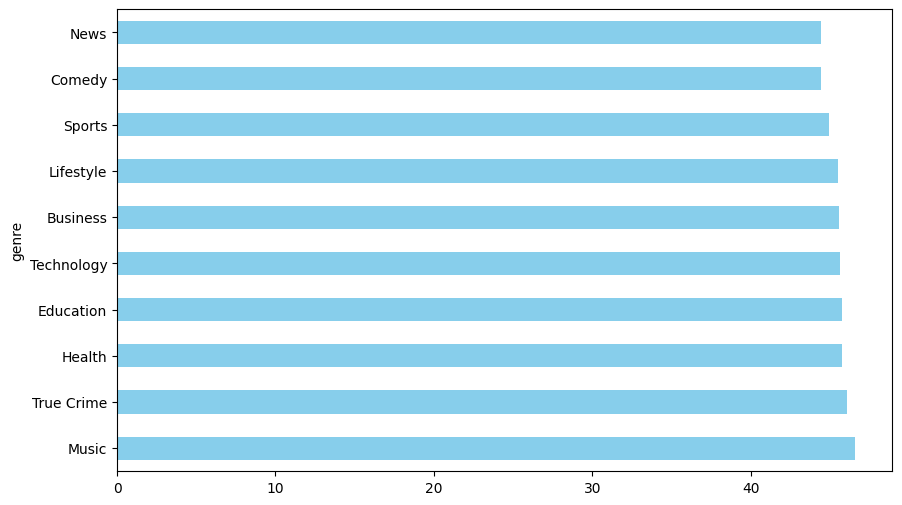

In [9]:
train.groupby('genre')['listening_time_minutes'].mean().sort_values(ascending=False).plot(kind='barh', figsize=(10, 6), color='skyblue')

In [10]:
train = train.drop(columns=['id','podcast_name', 'episode_title', 'genre'])
test = test.drop(columns=['id','podcast_name', 'episode_title', 'genre'])

In [11]:
target_placeholder = train.pop('listening_time_minutes')

train['listening_time_minutes'] = target_placeholder

train

,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage,number_of_ads,weekday_encoded,publication_encoded,episode_sentiment_encoded,listening_time_minutes
0,63.84,74.81,53.58,0.0,4,4,2,31.41998
1,119.80,66.95,75.95,2.0,6,1,0,88.01241
2,73.90,69.97,8.97,0.0,2,2,0,44.92531
3,67.17,57.22,78.70,2.0,1,0,2,46.27824
4,110.51,80.07,58.68,3.0,1,1,1,75.61031
...,...,...,...,...,...,...,...,...
749995,75.66,69.36,53.58,0.0,6,0,0,56.87058
749996,75.75,35.21,53.58,2.0,6,4,1,45.46242
749997,30.98,78.58,84.89,0.0,4,0,0,15.26000
749998,108.98,45.39,93.27,0.0,4,0,0,100.72939


In [12]:
train.dtypes

episode_length_minutes         float64
host_popularity_percentage     float64
guest_popularity_percentage    float64
number_of_ads                  float64
weekday_encoded                  int64
publication_encoded              int64
episode_sentiment_encoded        int64
listening_time_minutes         float64
dtype: object

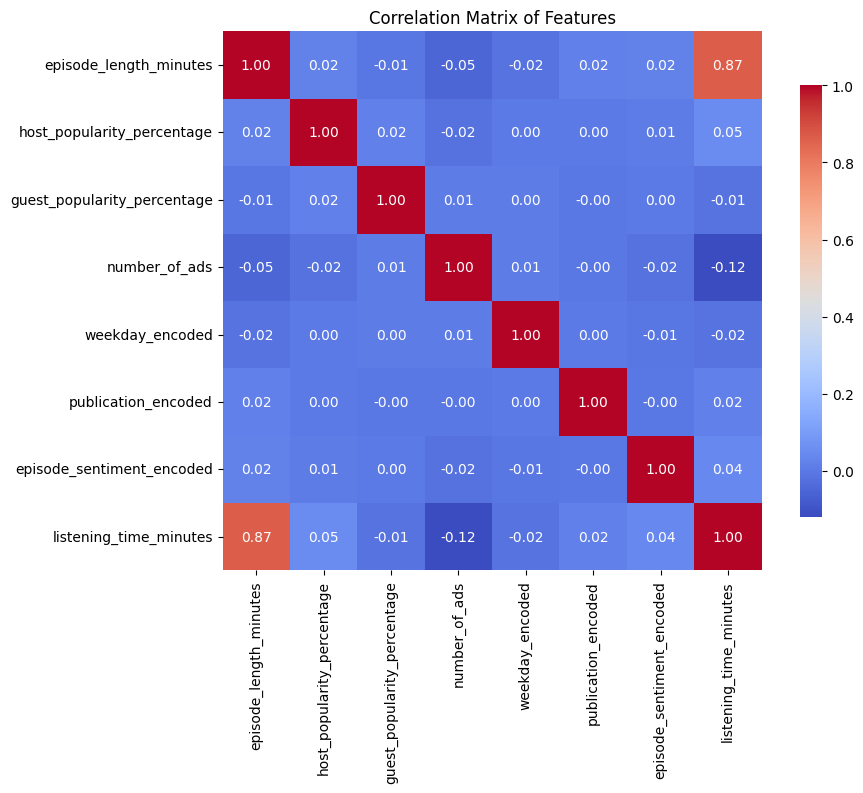

In [13]:
corr_matrix = train.corr()
plt.figure(figsize=(10, 7)) 
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Features')
plt.show()

In [14]:
train['combined_popularity'] = train['host_popularity_percentage'] * train['guest_popularity_percentage'] / 100.0   # converting to percentage
test['combined_popularity'] = test['host_popularity_percentage'] * test['guest_popularity_percentage'] / 100.0

train['popularity_difference'] = (train['host_popularity_percentage'] - train['guest_popularity_percentage'])
test['popularity_difference'] = (test['host_popularity_percentage'] - test['guest_popularity_percentage'])

print("Train df after creation of 2 new features: \n", train.head(3))
print("Test df after creation of 2 new features: \n", test.head(3))

Train df after creation of 2 new features: 
    episode_length_minutes  host_popularity_percentage  \
0                   63.84                       74.81   
1                  119.80                       66.95   
2                   73.90                       69.97   

   guest_popularity_percentage  number_of_ads  weekday_encoded  \
0                        53.58            0.0                4   
1                        75.95            2.0                6   
2                         8.97            0.0                2   

   publication_encoded  episode_sentiment_encoded  listening_time_minutes  \
0                    4                          2                31.41998   
1                    1                          0                88.01241   
2                    2                          0                44.92531   

   combined_popularity  popularity_difference  
0            40.083198                  21.23  
1            50.848525                  -9.00  
2       

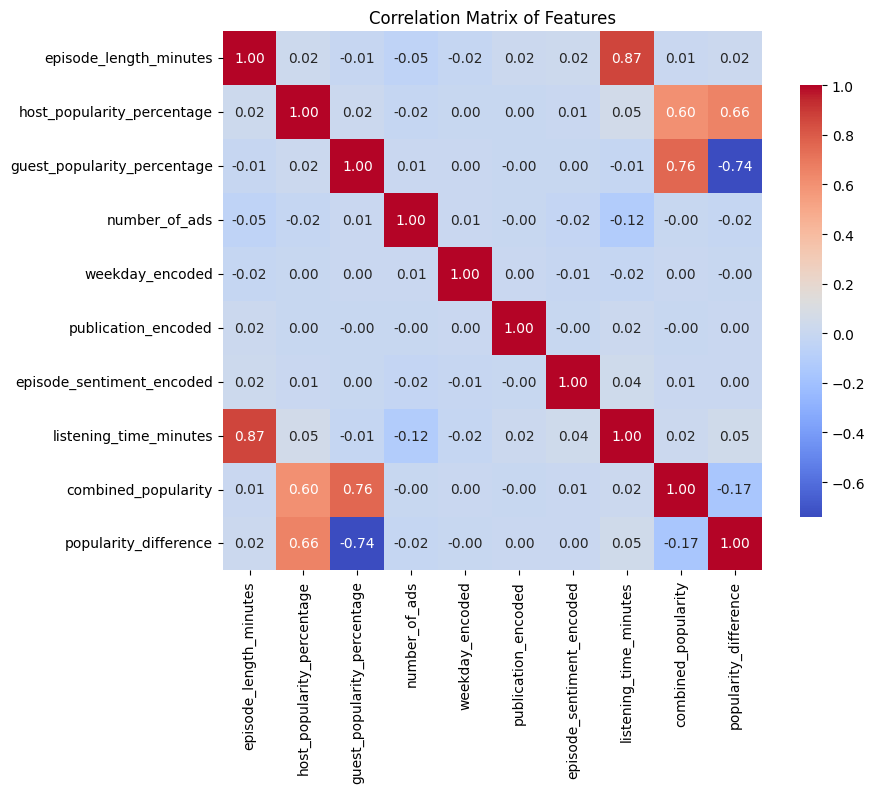

In [17]:
corr_matrix = train.corr()
plt.figure(figsize=(10, 7)) 
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Features')
plt.show()

In [18]:
train

,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage,number_of_ads,weekday_encoded,publication_encoded,episode_sentiment_encoded,listening_time_minutes,combined_popularity,popularity_difference
0,63.84,74.81,53.58,0.00,4,4,2,31.42,40.08,21.23
1,119.80,66.95,75.95,2.00,6,1,0,88.01,50.85,-9.00
2,73.90,69.97,8.97,0.00,2,2,0,44.93,6.28,61.00
3,67.17,57.22,78.70,2.00,1,0,2,46.28,45.03,-21.48
4,110.51,80.07,58.68,3.00,1,1,1,75.61,46.99,21.39
...,...,...,...,...,...,...,...,...,...,...
749995,75.66,69.36,53.58,0.00,6,0,0,56.87,37.16,15.78
749996,75.75,35.21,53.58,2.00,6,4,1,45.46,18.87,-18.37
749997,30.98,78.58,84.89,0.00,4,0,0,15.26,66.71,-6.31
749998,108.98,45.39,93.27,0.00,4,0,0,100.73,42.34,-47.88


In [15]:
weekend_days = [6, 7]

train['is_weekend'] = train['weekday_encoded'].apply(lambda x: 1 if x in weekend_days else 0)

In [16]:
train

,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage,number_of_ads,weekday_encoded,publication_encoded,episode_sentiment_encoded,listening_time_minutes,combined_popularity,popularity_difference,is_weekend
0,63.84,74.81,53.58,0.0,4,4,2,31.41998,40.083198,21.23,0
1,119.80,66.95,75.95,2.0,6,1,0,88.01241,50.848525,-9.00,1
2,73.90,69.97,8.97,0.0,2,2,0,44.92531,6.276309,61.00,0
3,67.17,57.22,78.70,2.0,1,0,2,46.27824,45.032140,-21.48,0
4,110.51,80.07,58.68,3.0,1,1,1,75.61031,46.985076,21.39,0
...,...,...,...,...,...,...,...,...,...,...,...
749995,75.66,69.36,53.58,0.0,6,0,0,56.87058,37.163088,15.78,1
749996,75.75,35.21,53.58,2.0,6,4,1,45.46242,18.865518,-18.37,1
749997,30.98,78.58,84.89,0.0,4,0,0,15.26000,66.706562,-6.31,0
749998,108.98,45.39,93.27,0.0,4,0,0,100.72939,42.335253,-47.88,0


In [17]:
target_placeholder = train.pop('listening_time_minutes')

train['listening_time_minutes'] = target_placeholder

train

,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage,number_of_ads,weekday_encoded,publication_encoded,episode_sentiment_encoded,combined_popularity,popularity_difference,is_weekend,listening_time_minutes
0,63.84,74.81,53.58,0.0,4,4,2,40.083198,21.23,0,31.41998
1,119.80,66.95,75.95,2.0,6,1,0,50.848525,-9.00,1,88.01241
2,73.90,69.97,8.97,0.0,2,2,0,6.276309,61.00,0,44.92531
3,67.17,57.22,78.70,2.0,1,0,2,45.032140,-21.48,0,46.27824
4,110.51,80.07,58.68,3.0,1,1,1,46.985076,21.39,0,75.61031
...,...,...,...,...,...,...,...,...,...,...,...
749995,75.66,69.36,53.58,0.0,6,0,0,37.163088,15.78,1,56.87058
749996,75.75,35.21,53.58,2.0,6,4,1,18.865518,-18.37,1,45.46242
749997,30.98,78.58,84.89,0.0,4,0,0,66.706562,-6.31,0,15.26000
749998,108.98,45.39,93.27,0.0,4,0,0,42.335253,-47.88,0,100.72939


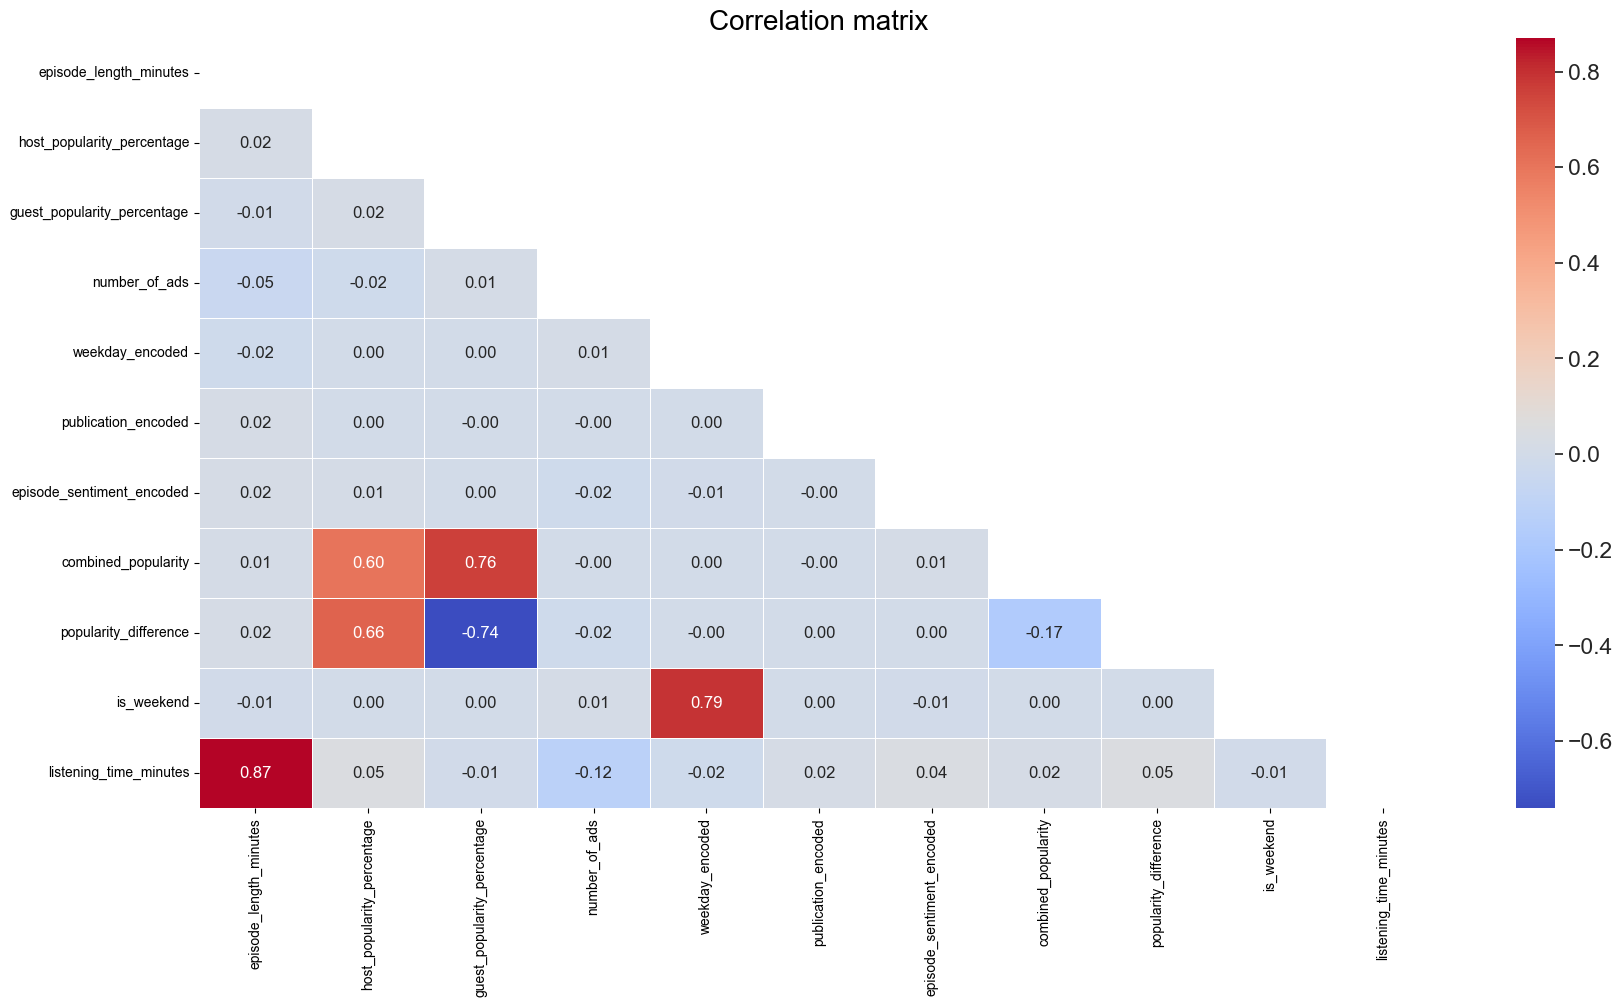

In [18]:
num_corr = round(train.corr(), 2)

# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

f, ax = plt.subplots(figsize=(20, 10))
sns.set_theme(font_scale=1.5) # increase font size

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation matrix", fontsize=20) # add title
plt.show()

In [19]:
train = train.drop(columns=['host_popularity_percentage', 'guest_popularity_percentage', 'weekday_encoded'])
test = test.drop(columns=['host_popularity_percentage', 'guest_popularity_percentage', 'weekday_encoded'])

train

,episode_length_minutes,number_of_ads,publication_encoded,episode_sentiment_encoded,combined_popularity,popularity_difference,is_weekend,listening_time_minutes
0,63.84,0.0,4,2,40.083198,21.23,0,31.41998
1,119.80,2.0,1,0,50.848525,-9.00,1,88.01241
2,73.90,0.0,2,0,6.276309,61.00,0,44.92531
3,67.17,2.0,0,2,45.032140,-21.48,0,46.27824
4,110.51,3.0,1,1,46.985076,21.39,0,75.61031
...,...,...,...,...,...,...,...,...
749995,75.66,0.0,0,0,37.163088,15.78,1,56.87058
749996,75.75,2.0,4,1,18.865518,-18.37,1,45.46242
749997,30.98,0.0,0,0,66.706562,-6.31,0,15.26000
749998,108.98,0.0,0,0,42.335253,-47.88,0,100.72939


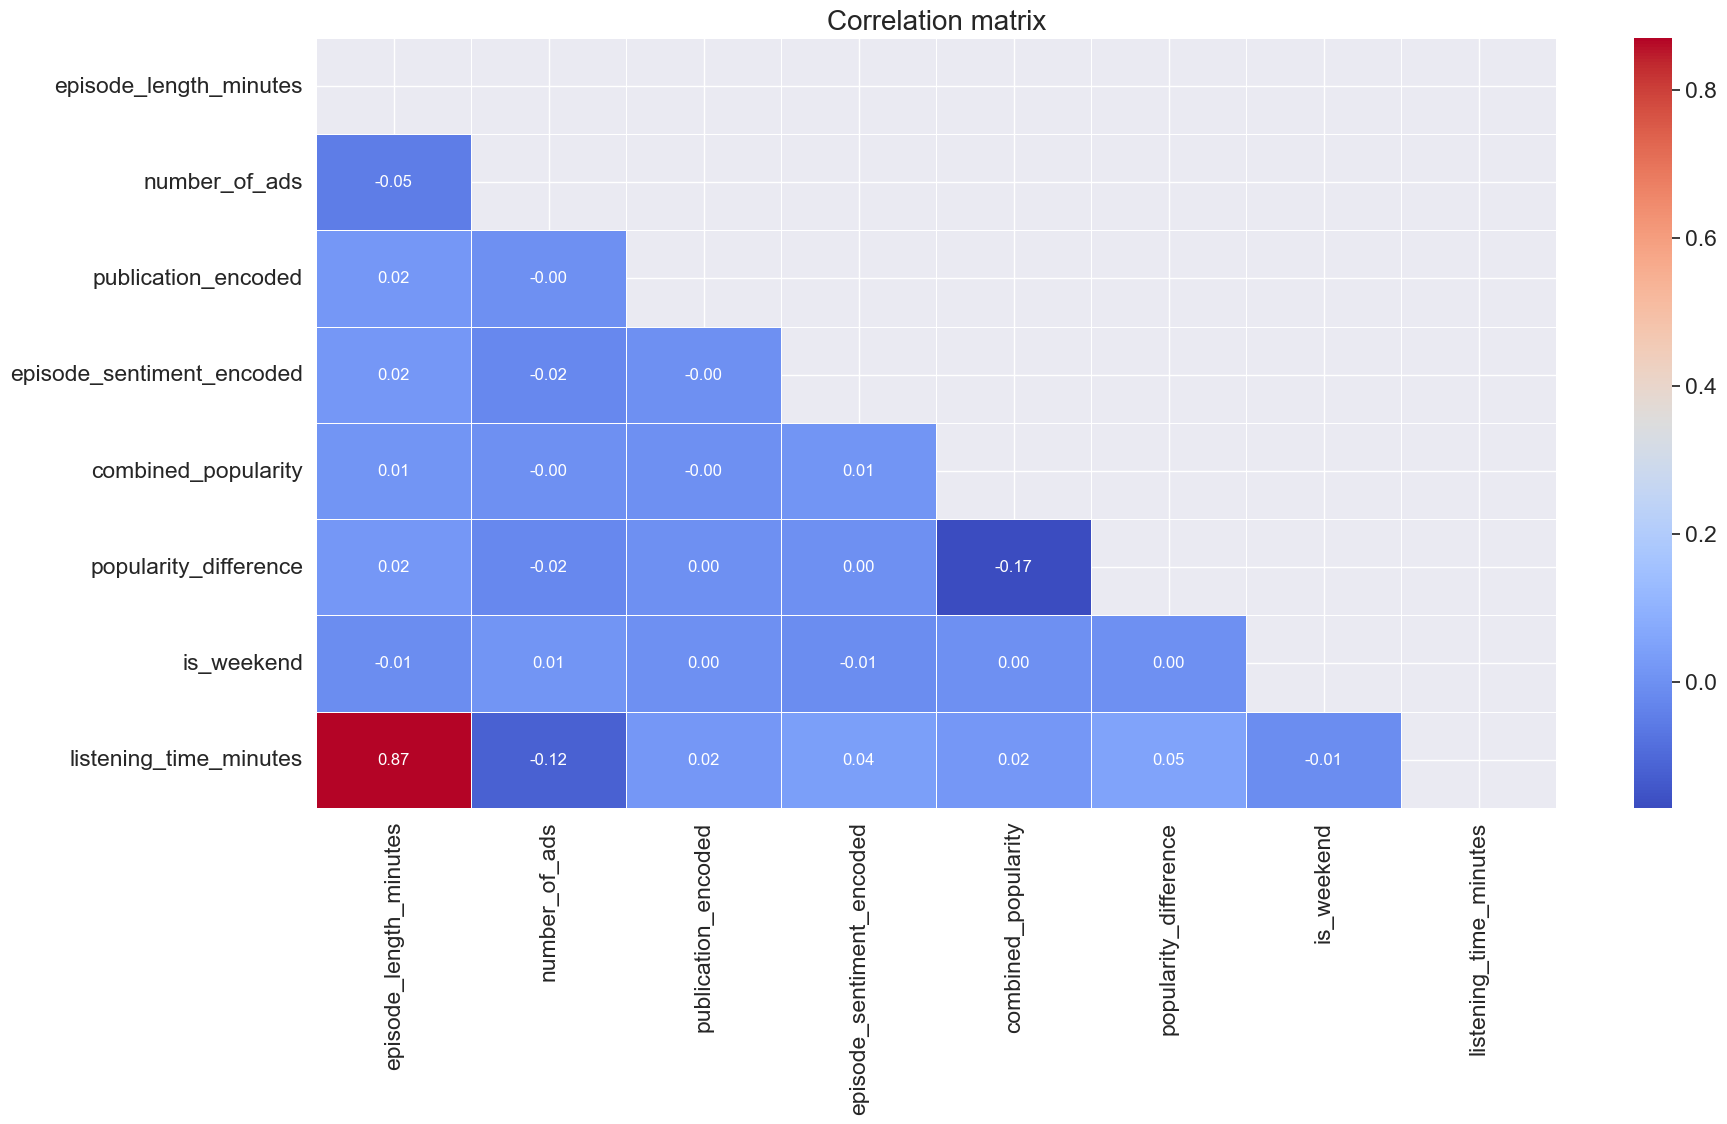

In [20]:
num_corr = round(train.corr(), 2)

# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

f, ax = plt.subplots(figsize=(20, 10))
sns.set_theme(font_scale=1.5) # increase font size

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation matrix", fontsize=20) # add title
plt.show()

# Training

In [21]:
from sklearn.model_selection import train_test_split

X = train.drop(columns='listening_time_minutes') #target
y = train['listening_time_minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [23]:
def train_and_eval_models(X_train, X_test, y_train, y_test):

    #models to test
    models = {
        "Linear Regression" : LinearRegression(),
        "Random Forest" : RandomForestRegressor(),
        "XGB" : XGBRegressor()
    }

    print("Starting the training process.")

    #list to store results

    results = []

    #scaling data just for LinearRegression

    for name, model in models.items():
        print(f"Training model: {name}")

        model.fit(X_train, y_train)

        y_train_predict = model.predict(X_train)
        y_test_predict = model.predict(X_test)

        results.append({
            "Model": name,
            "Train MAE": mean_absolute_error(y_train, y_train_predict),
            "Test MAE": mean_absolute_error(y_test, y_test_predict),
            "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_predict)),
            "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_predict)),
            "Train R2": r2_score(y_train, y_train_predict),
            "Test R2": r2_score(y_test, y_test_predict)
        })

    # Converting results into a DataFrame
    results_df = pd.DataFrame(results)

    print("\nModel Performance Summary:")
    print(results_df)

    return results_df

In [28]:
results_df = train_and_eval_models(X_train, X_test, y_train, y_test)

print(results_df)

Starting the training process.
Training model: Linear Regression
Training model: Random Forest
Training model: XGB

Model Performance Summary:
               Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  \
0  Linear Regression       9.83      9.78       13.38      13.35      0.76   
1      Random Forest       3.43      9.20        4.93      13.08      0.97   
2                XGB       9.47      9.54       13.00      13.12      0.77   

   Test R2  
0     0.76  
1     0.77  
2     0.77  
               Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  \
0  Linear Regression       9.83      9.78       13.38      13.35      0.76   
1      Random Forest       3.43      9.20        4.93      13.08      0.97   
2                XGB       9.47      9.54       13.00      13.12      0.77   

   Test R2  
0     0.76  
1     0.77  
2     0.77  


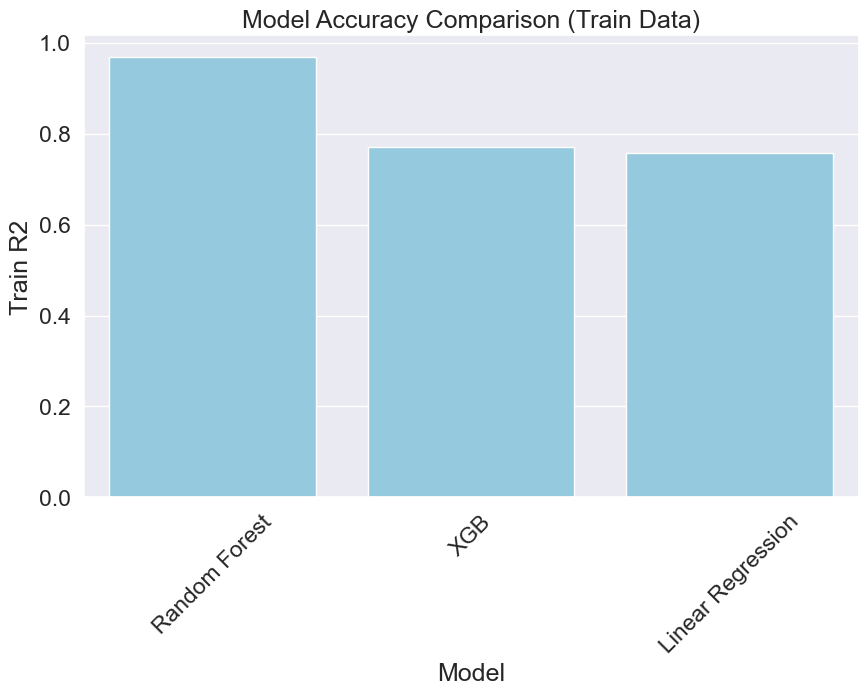

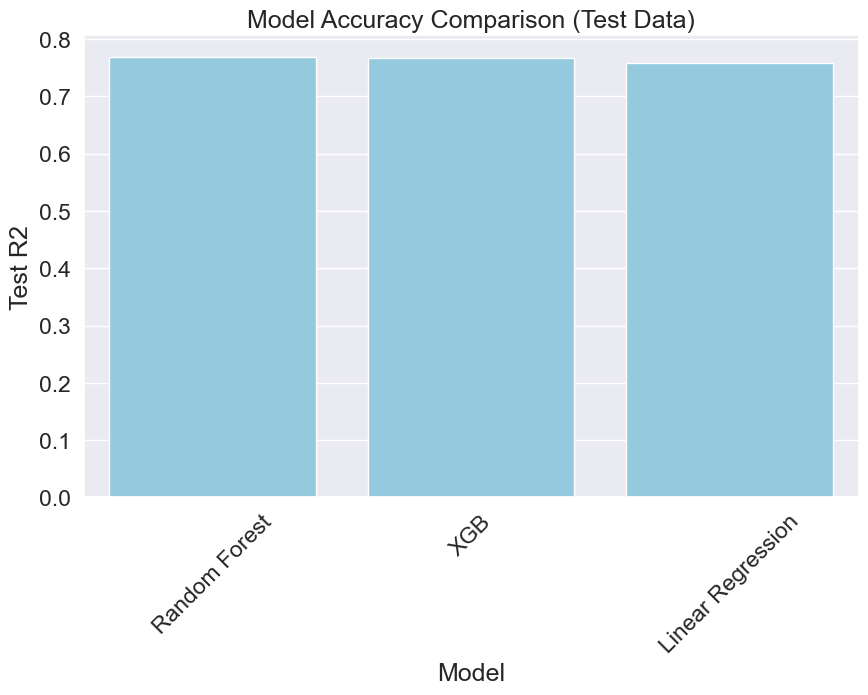

In [29]:
#plotting the results

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Train R2", data=results_df.sort_values(by='Train R2', ascending=False), color='skyblue')
plt.title("Model Accuracy Comparison (Train Data)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Test R2", data=results_df.sort_values(by='Test R2', ascending=False), color='skyblue')
plt.title("Model Accuracy Comparison (Test Data)")
plt.xticks(rotation=45)
plt.show()

In [30]:
def xgbhyper(X_train, X_test, y_train, y_test):

    #models to test
    models = {
        "XGB" : XGBRegressor(max_depth= 3)
    }

    print("Starting the training process.")

    #list to store results

    results = []

    #scaling data just for LogisticRegression

    for name, model in models.items():
        print(f"Training model: {name}")

        model.fit(X_train, y_train)

        y_train_predict = model.predict(X_train)
        y_test_predict = model.predict(X_test)

        results.append({
            "Model": name,
            "Train MAE": mean_absolute_error(y_train, y_train_predict),
            "Test MAE": mean_absolute_error(y_test, y_test_predict),
            "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_predict)),
            "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_predict)),
            "Train R2": r2_score(y_train, y_train_predict),
            "Test R2": r2_score(y_test, y_test_predict)
        })

    # Converting results into a DataFrame
    results_df = pd.DataFrame(results)

    print("\nModel Performance Summary:")
    print(results_df)

    return results_df

In [31]:
results_xgb_df = xgbhyper(X_train, X_test, y_train, y_test)

print(results_xgb_df)

Starting the training process.
Training model: XGB

Model Performance Summary:
  Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  Test R2
0   XGB       9.61      9.58       13.19      13.15      0.76     0.76
  Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  Test R2
0   XGB       9.61      9.58       13.19      13.15      0.76     0.76


# my models
baseline and hyperparameter tuned

In [24]:
#copy of test train split(following same naming convention)
from sklearn.model_selection import train_test_split

X = train.drop(columns='listening_time_minutes') #target
y = train['listening_time_minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

regr = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = regr.fit(X_train, X_test, y_train, y_test)

print(models.head())

  0%|          | 0/42 [00:00<?, ?it/s]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_baseline = LinearRegression()
model_baseline.fit(X, y)

LinearRegression()

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, GridSearchCV

def select_best_linear_pipeline(X, y, cv=5):
    """
    Performs model selection for a linear regression pipeline using cross-validation and grid search.

    Parameters:
        X (array-like): Feature data.
        y (array-like): Continuous target variable.
        cv (int): Number of cross-validation folds (default is 5).

    Returns:
        best_pipeline: The best estimator found by GridSearchCV.
    """
    pipeline_linear = Pipeline([
      ('scaler', StandardScaler()),
      ('poly', PolynomialFeatures()),
      ('model', LinearRegression())
    ])

    param_grid = {
      'poly__degree': [1, 2, 3],
      'poly__interaction_only': [True, False],
      'model__fit_intercept': [True, False],
      'model__positive': [True, False]
    }

    # Evaluate the pipeline with cross-validation
    scores = cross_val_score(pipeline_linear, X, y, cv=cv, scoring='r2')
    print('Cross-Validation R2 scores:', scores)
    print('Mean CV R2:', scores.mean())

    # Set up and run grid search
    grid_search = GridSearchCV(pipeline_linear, param_grid, cv=cv, scoring='r2')
    grid_search.fit(X, y)

    # Print best parameters and score
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation R2 score:", grid_search.best_score_)

    # Return the best estimator for further predictions
    return grid_search.best_estimator_

In [27]:
best_pipeline = select_best_linear_pipeline(X, y, cv=5)
print("Best pipeline:", best_pipeline)

Cross-Validation R2 scores: [0.7579904  0.75911094 0.76224506 0.76273801 0.76130024]
Mean CV R2: 0.7606769318528774
Best parameters: {'model__fit_intercept': True, 'model__positive': False, 'poly__degree': 2, 'poly__interaction_only': False}
Best cross-validation R2 score: 0.7606769318528774
Best pipeline: Pipeline(steps=[('scaler', StandardScaler()), ('poly', PolynomialFeatures()),
                ('model', LinearRegression())])
